In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sodapy import Socrata

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARMA, AR
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [4]:
creds_file = open('./creds.json', 'r')
socrata_creds = json.loads(creds_file.read())

In [5]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", socrata_creds['app_token'])

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# Data
---

### DHS Daily Report
Source: https://data.cityofnewyork.us/Social-Services/DHS-Daily-Report/k46n-sa2m

This dataset includes the daily number of families and individuals residing in the Department of Homeless Services (DHS) shelter system and the daily number of families applying to the DHS shelter system.

In [6]:
# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("k46n-sa2m", limit = 10_000);

# Convert to pandas DataFrame
daily_df = pd.DataFrame.from_records(results);

In [81]:
results

[{'date_of_census': '2019-11-18T00:00:00.000',
  'total_adults_in_shelter': '38602',
  'total_children_in_shelter': '21861',
  'total_individuals_in_shelter': '60463',
  'single_adult_men_in_shelter': '12270',
  'single_adult_women_in_shelter': '4638',
  'total_single_adults_in_shelter': '16908',
  'families_with_children_in_shelter': '12261',
  'adults_in_families_with_children_in_shelter': '16412',
  'children_in_families_with_children_in_shelter': '21861',
  'total_individuals_in_families_with_children_in_shelter_': '38273',
  'adult_families_in_shelter': '2510',
  'individuals_in_adult_families_in_shelter': '5282'},
 {'date_of_census': '2019-11-17T00:00:00.000',
  'total_adults_in_shelter': '38544',
  'total_children_in_shelter': '21893',
  'total_individuals_in_shelter': '60437',
  'single_adult_men_in_shelter': '12199',
  'single_adult_women_in_shelter': '4625',
  'total_single_adults_in_shelter': '16824',
  'families_with_children_in_shelter': '12275',
  'adults_in_families_with

In [7]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 13 columns):
date_of_census                                             2218 non-null object
total_adults_in_shelter                                    2218 non-null object
total_children_in_shelter                                  2218 non-null object
total_individuals_in_shelter                               2218 non-null object
single_adult_men_in_shelter                                2218 non-null object
single_adult_women_in_shelter                              2218 non-null object
total_single_adults_in_shelter                             2218 non-null object
families_with_children_in_shelter                          2218 non-null object
adults_in_families_with_children_in_shelter                2218 non-null object
children_in_families_with_children_in_shelter              2218 non-null object
total_individuals_in_families_with_children_in_shelter_    2218 non-null object
adult_familie

# Functions

In [8]:
def adf(series_to_try):
    """
    a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
    """
    dftest = adfuller(series_to_try)
    result = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return result

In [9]:
def acf_pacf(series_to_plot, n_lag):
    """
    Plot ACF & PACF
    """
    plot_acf(series_to_plot, lags = n_lag);
    plt.ylabel('autocorrelation')
    plt.xlabel('lags');

    plot_pacf(series_to_plot, lags = n_lag);
    plt.ylabel('partial autocorrelation')
    plt.xlabel('lags');

In [10]:
def evaluate(data_to_evaluate, residual):
    
    """
    make residual graphs and print out MSE 
    """

    plt.figure(figsize = (12,5))
    plt.scatter(data_to_evaluate.index, residual)
    plt.title('Residuals')
    plt.axhline(0, color='red')

    return {"mean square error": sum(np.square(residual)) / len(residual)}

# Data Cleaning

The type of all columns is 'object'. `date_of_census` is datetime column and rest of the columns are numerical column. Change the types appropriately.

In [11]:
daily_df['date_of_census'] = daily_df['date_of_census'].apply(lambda x: x.split('T')[0])

In [12]:
daily_df.index = pd.to_datetime(daily_df['date_of_census'], format = "%Y/%m/%d")
daily_df = daily_df.drop('date_of_census', axis = 1)

In [13]:
daily_df = daily_df.apply(pd.to_numeric)

In [14]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2218 entries, 2019-11-18 to 2013-08-21
Data columns (total 12 columns):
total_adults_in_shelter                                    2218 non-null int64
total_children_in_shelter                                  2218 non-null int64
total_individuals_in_shelter                               2218 non-null int64
single_adult_men_in_shelter                                2218 non-null int64
single_adult_women_in_shelter                              2218 non-null int64
total_single_adults_in_shelter                             2218 non-null int64
families_with_children_in_shelter                          2218 non-null int64
adults_in_families_with_children_in_shelter                2218 non-null int64
children_in_families_with_children_in_shelter              2218 non-null int64
total_individuals_in_families_with_children_in_shelter_    2218 non-null int64
adult_families_in_shelter                                  2218 non-null int64
indivi

When resampled by day ('D'), some rows are created. This indicates that missing days exist and these were filled in with null values.

In [15]:
daily_df.shape

(2218, 12)

In [16]:
daily_df.resample('D').mean().shape

(2281, 12)

Resampled by week('W') to avoid having any missing days.

In [17]:
daily_df.resample('W').mean().shape

(327, 12)

In [18]:
daily_df.resample('W').mean().isnull().sum()

total_adults_in_shelter                                    0
total_children_in_shelter                                  0
total_individuals_in_shelter                               0
single_adult_men_in_shelter                                0
single_adult_women_in_shelter                              0
total_single_adults_in_shelter                             0
families_with_children_in_shelter                          0
adults_in_families_with_children_in_shelter                0
children_in_families_with_children_in_shelter              0
total_individuals_in_families_with_children_in_shelter_    0
adult_families_in_shelter                                  0
individuals_in_adult_families_in_shelter                   0
dtype: int64

In [19]:
weekly_df = daily_df.resample('W').mean()

In [20]:
weekly_df.index

DatetimeIndex(['2013-08-25', '2013-09-01', '2013-09-08', '2013-09-15',
               '2013-09-22', '2013-09-29', '2013-10-06', '2013-10-13',
               '2013-10-20', '2013-10-27',
               ...
               '2019-09-22', '2019-09-29', '2019-10-06', '2019-10-13',
               '2019-10-20', '2019-10-27', '2019-11-03', '2019-11-10',
               '2019-11-17', '2019-11-24'],
              dtype='datetime64[ns]', name='date_of_census', length=327, freq='W-SUN')

# EDA

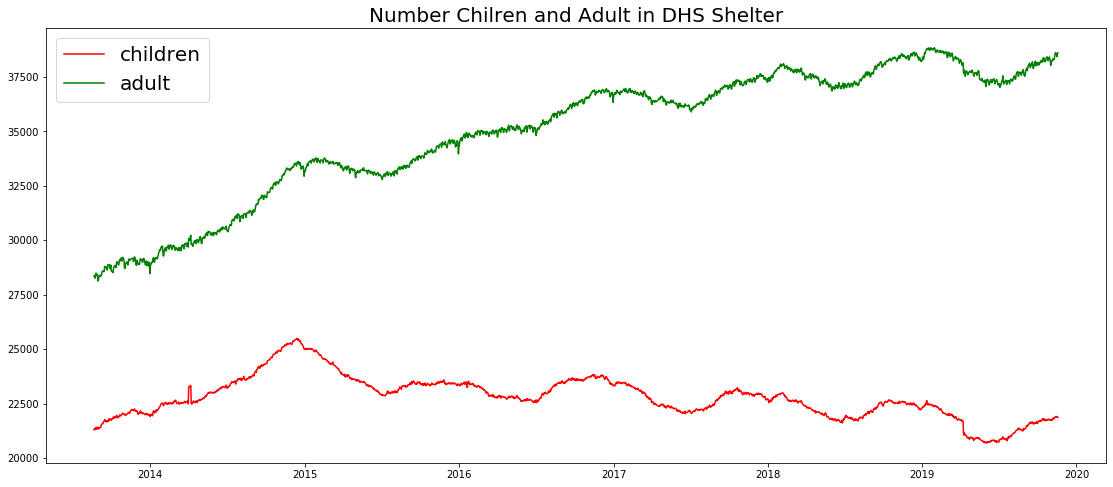

In [21]:
plt.figure(figsize = (19, 8))
plt.plot(daily_df['total_children_in_shelter'],color = 'red', label = 'children')
plt.plot(daily_df['total_adults_in_shelter'],color = 'green', label = 'adult')
plt.title('Number Chilren and Adult in DHS Shelter', fontsize = 20)
plt.legend(fontsize = 20)

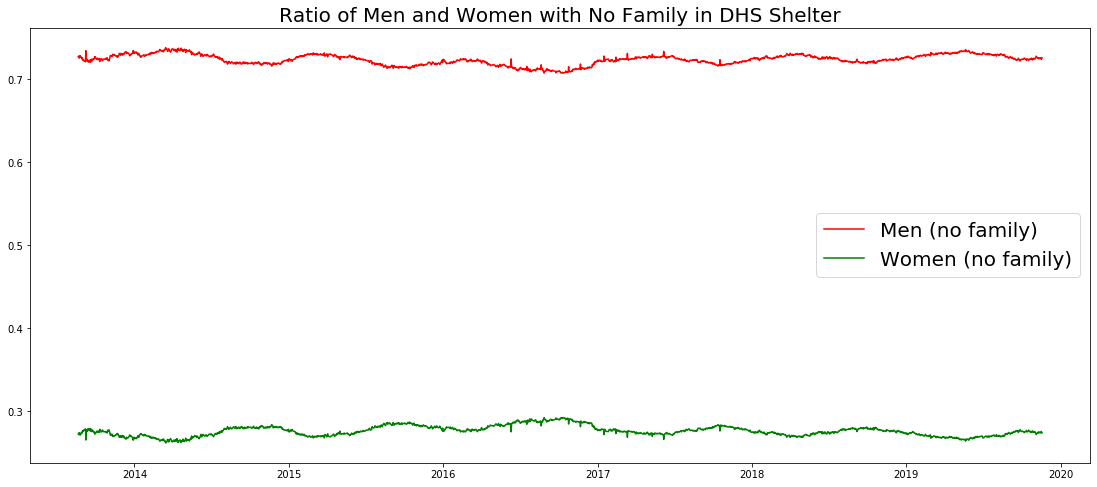

In [22]:
plt.figure(figsize = (19, 8))

plt.plot(daily_df['single_adult_men_in_shelter'] / daily_df['total_single_adults_in_shelter'],
         color = 'red', label = 'Men (no family)')
plt.plot(daily_df['single_adult_women_in_shelter']/ daily_df['total_single_adults_in_shelter']
         ,color = 'green', label = 'Women (no family)')
plt.title('Ratio of Men and Women with No Family in DHS Shelter', fontsize = 20)
plt.legend(fontsize = 20)

look into war veteran data (more men)

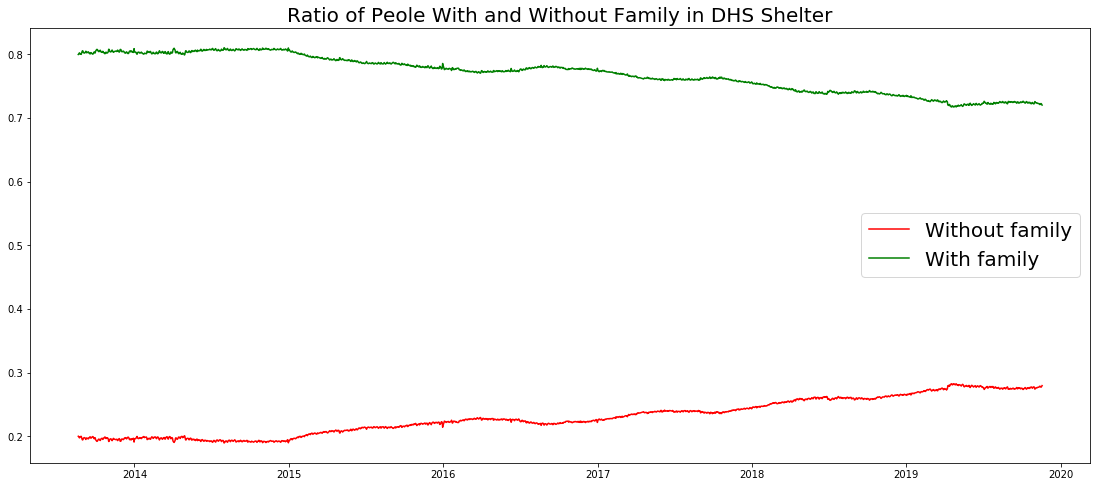

In [23]:
plt.figure(figsize = (19, 8))
plt.plot(daily_df['total_single_adults_in_shelter'] / daily_df['total_individuals_in_shelter'],
         color = 'red', label = 'Without family')
plt.plot((daily_df['total_individuals_in_families_with_children_in_shelter_']\
          + daily_df['individuals_in_adult_families_in_shelter'])/ daily_df['total_individuals_in_shelter']
         ,color = 'green', label = 'With family')
plt.title('Ratio of Peole With and Without Family in DHS Shelter', fontsize = 20)
plt.legend(fontsize = 20)

- Check DHS policy about family
- Is this related to men having higher criminal record?

# Target EDA ( weekly_df )

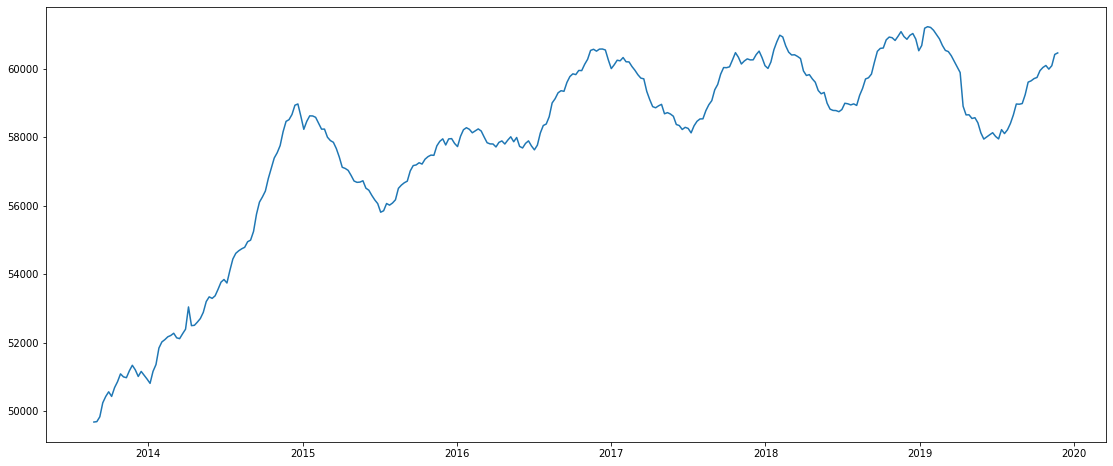

In [24]:
plt.figure(figsize = (19, 8))
plt.plot(weekly_df['total_individuals_in_shelter'], label = 'total') 

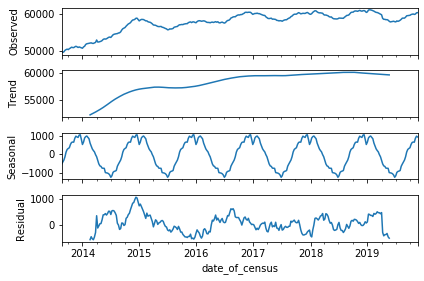

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(weekly_df['total_individuals_in_shelter'])
decomp.plot();

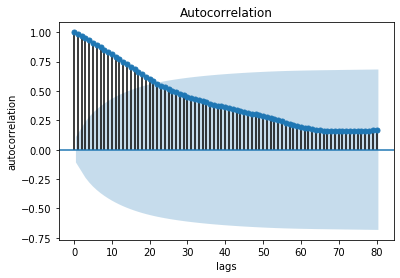

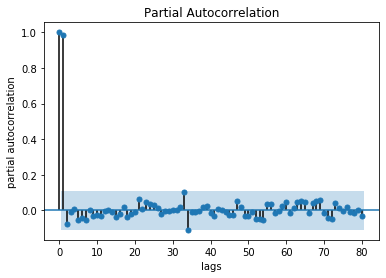

In [26]:
acf_pacf(weekly_df['total_individuals_in_shelter'], 80)

The small lags values have large and positive correlations. This is a evidence of a trend.

The evidence of seasonailty observed in seasonal_decompose plot is not very evident in PACF plot.

# Try OLS regression

In [27]:
weekly_lag = weekly_df.copy()

In [28]:
# Create a column called `lag_1` that lags Passengers by one month.
weekly_df['lag_1'] = weekly_df['total_individuals_in_shelter'].shift(1)

# Create a column called `lag_2` that lags Passengers by two months.
weekly_df['lag_2'] = weekly_df['total_individuals_in_shelter'].shift(2)

weekly_df['lag_3'] = weekly_df['total_individuals_in_shelter'].shift(3)

In [29]:
weekly_df.loc[:,['total_individuals_in_shelter','lag_1', 'lag_2', 'lag_3']].corr()

,total_individuals_in_shelter,lag_1,lag_2,lag_3
total_individuals_in_shelter,1.000000,0.997918,0.994146,0.989735
lag_1,0.997918,1.000000,0.997913,0.994158
lag_2,0.994146,0.997913,1.000000,0.997928
lag_3,0.989735,0.994158,0.997928,1.000000


### OLS model 1
- Includes lag1,2 and 3

In [30]:
X = weekly_df.loc[:,['total_individuals_in_shelter','lag_1', 'lag_2', 'lag_3']]\
    .drop('total_individuals_in_shelter', axis = 1)
y = weekly_df['total_individuals_in_shelter']

In [31]:
# Generate train/test split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    shuffle = False)

In [32]:
# Before fitting a model in statsmodels, what do we need
# to do? (Hint: Think intercept.)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Confirm.
X_train.head()

/Users/dae/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,lag_1,lag_2,lag_3
date_of_census,,,,
2013-08-25,1.0,NaN,NaN,NaN
2013-09-01,1.0,49677.200000,NaN,NaN
2013-09-08,1.0,49689.000000,49677.2,NaN
2013-09-15,1.0,49829.600000,49689.0,49677.2
2013-09-22,1.0,50238.714286,49829.6,49689.0


In [33]:
# statsmodels won't be able to handle missing values.

X_train.dropna(inplace = True)

y_train = y_train[X_train.index]

In [34]:
X_train.head()

,const,lag_1,lag_2,lag_3
date_of_census,,,,
2013-09-15,1.0,49829.600000,49689.000000,49677.200000
2013-09-22,1.0,50238.714286,49829.600000,49689.000000
2013-09-29,1.0,50423.285714,50238.714286,49829.600000
2013-10-06,1.0,50560.571429,50423.285714,50238.714286
2013-10-13,1.0,50426.000000,50560.571429,50423.285714


In [35]:
# Remember that, in statsmodels, we pass our data 
# in when we instantiate the model!

lm = sm.OLS(y_train, X_train)

In [36]:
# Then we fit our model.
lm_results = lm.fit()

In [37]:
# Display our summary!
print(lm_results.summary())

                                 OLS Regression Results                                 
Dep. Variable:     total_individuals_in_shelter   R-squared:                       0.997
Model:                                      OLS   Adj. R-squared:                  0.997
Method:                           Least Squares   F-statistic:                 2.608e+04
Date:                          Thu, 21 Nov 2019   Prob (F-statistic):          7.64e-316
Time:                                  00:14:59   Log-Likelihood:                -1675.7
No. Observations:                           258   AIC:                             3359.
Df Residuals:                               254   BIC:                             3374.
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

**Observations**
- P-value for 'lag_3' is 0.995. This indicates that 'lag_3' is not statistically significant. This is indicated in the PACF plot above as well.

In [38]:
# Generate predicted test values.
lm_results.predict(X_test)

date_of_census
2018-08-26    59504.230142
2018-09-02    59802.323694
2018-09-09    59748.027501
2018-09-16    59882.025607
2018-09-23    60312.403667
                  ...     
2019-10-27    60067.718391
2019-11-03    60112.002061
2019-11-10    59945.682919
2019-11-17    60121.490410
2019-11-24    60532.709235
Freq: W-SUN, Length: 66, dtype: float64

In [39]:
resids = y_test - lm_results.predict(X_test)

{'mean square error': 36771.947469784034}

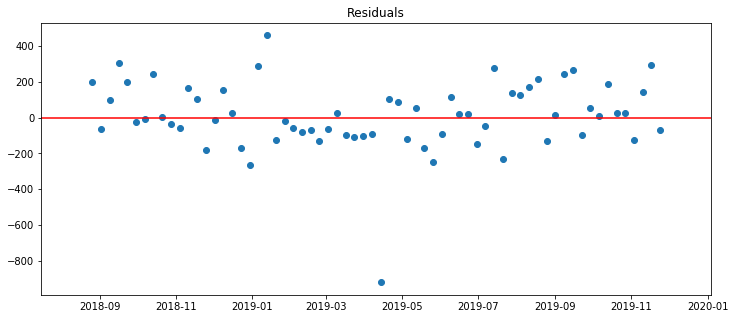

In [40]:
evaluate(y_test, resids)

In [41]:
# Calculate R2 score.
r2_score(y_test, lm_results.predict(X_test))

0.9676059216651622

In [42]:
# Calculate RMSE.
mean_squared_error(y_test, lm_results.predict(X_test)) ** 0.5

191.76013003172488

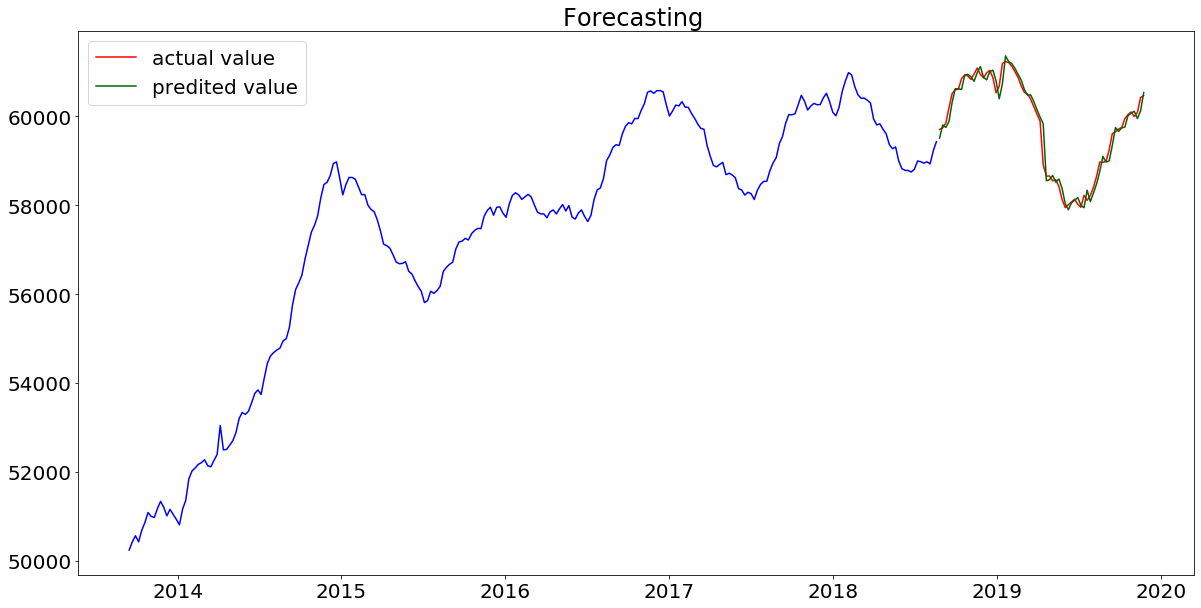

In [43]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(y_train.index, y_train.values, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'red', label = 'actual value')

# Plot predicted test values.
plt.plot(lm_results.predict(X_test), color = 'darkgreen', label = 'predited value')

# Set label.
plt.title(label = 'Forecasting ', fontsize=24)
plt.legend(fontsize = 20)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

(736932.0, 737387.0)

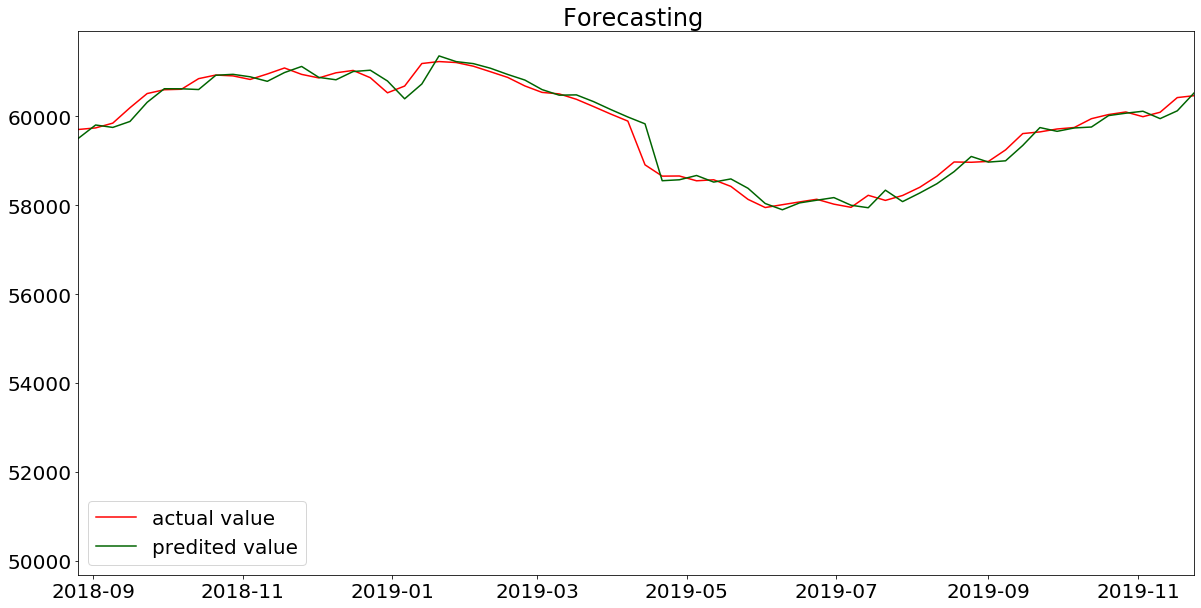

In [44]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(y_train.index, y_train.values, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'red', label = 'actual value')

# Plot predicted test values.
plt.plot(lm_results.predict(X_test), color = 'darkgreen', label = 'predited value')

# Set label.
plt.title(label = 'Forecasting ', fontsize=24)
plt.legend(fontsize = 20)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

plt.xlim(y_test.index[0], y_test.index[-1])

**Observations**
- My forecasting is perfect? Some thing is not right here.
- bc it's based off the lag value of itself (data seems reactionary)

### OLS model 2
- Includes lag1,2 (not 3)

In [45]:
X = weekly_df.loc[:,['total_individuals_in_shelter','lag_1', 'lag_2']]\
    .drop('total_individuals_in_shelter', axis = 1)
y = weekly_df['total_individuals_in_shelter']

# Generate train/test split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    shuffle = False)


# Before fitting a model in statsmodels, what do we need
# to do? (Hint: Think intercept.)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# statsmodels won't be able to handle missing values.
X_train.dropna(inplace = True)

y_train = y_train[X_train.index]

/Users/dae/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [46]:
# Remember that, in statsmodels, we pass our data 
# in when we instantiate the model!

lm = sm.OLS(y_train, X_train)

# Then we fit our model.
lm_results = lm.fit()

# Display our summary!
print(lm_results.summary())

                                 OLS Regression Results                                 
Dep. Variable:     total_individuals_in_shelter   R-squared:                       0.997
Model:                                      OLS   Adj. R-squared:                  0.997
Method:                           Least Squares   F-statistic:                 4.051e+04
Date:                          Thu, 21 Nov 2019   Prob (F-statistic):          6.05e-321
Time:                                  00:15:00   Log-Likelihood:                -1681.7
No. Observations:                           259   AIC:                             3369.
Df Residuals:                               256   BIC:                             3380.
Df Model:                                     2                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [47]:
# Generate predicted test values.
lm_results.predict(X_test);

# Calculate R2 score.
r2_score(y_test, lm_results.predict(X_test))

0.9675962982196475

In [48]:
# Calculate RMSE.
mean_squared_error(y_test, lm_results.predict(X_test)) ** 0.5

191.78861141202316

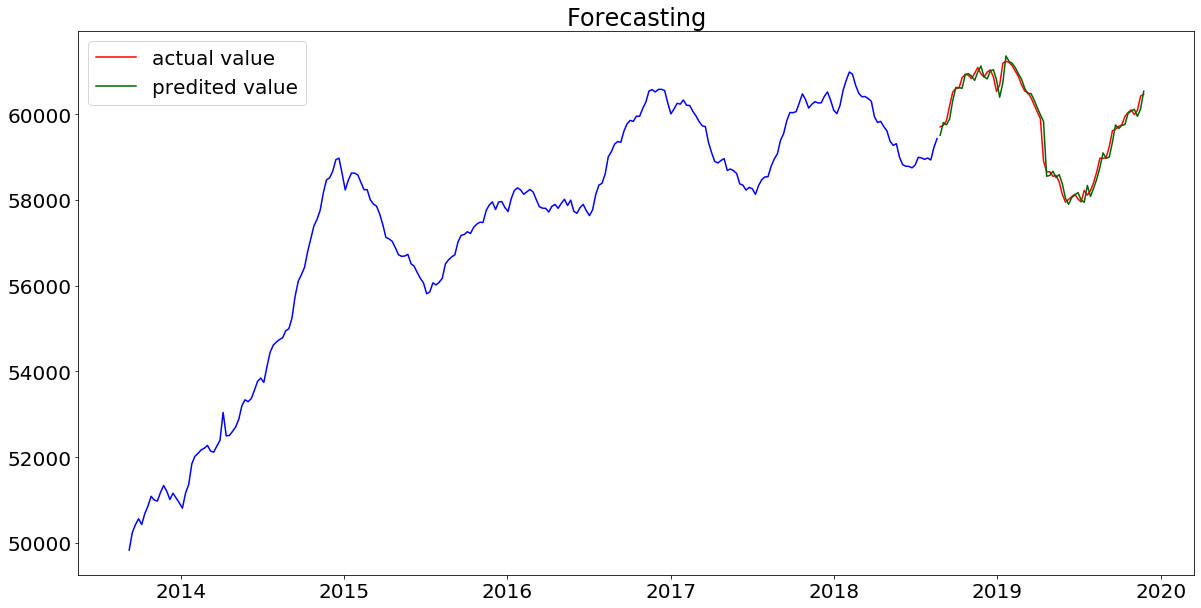

In [49]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(y_train.index, y_train.values, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'red', label = 'actual value')

# Plot predicted test values.
plt.plot(lm_results.predict(X_test), color = 'darkgreen', label = 'predited value')

# Set label.
plt.title(label = 'Forecasting', fontsize=24)
plt.legend(fontsize = 20)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

**Observations**
- RMSE slight increased when lag_3 was removed.

# ARIMA Model

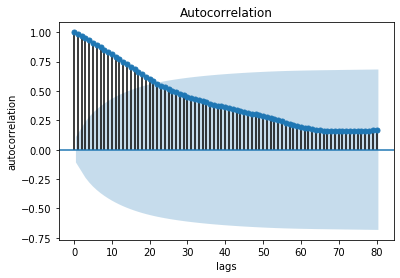

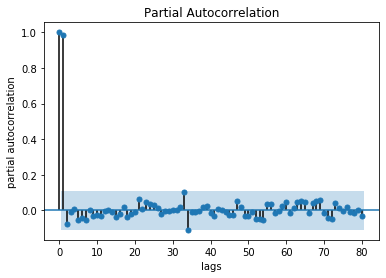

In [50]:
acf_pacf(weekly_df['total_individuals_in_shelter'], 80)

### Decide what 'order (p, d, q)' for the model
`p` (AR: AutoRegression)
- In the PACF plot, there is a sharp cut-off in lag 3.
- lag 1 value is positive.                  
--> p-value is a lag right before the cut-off. **p=1**

`d` (I: Integration)
- By differencing the data once, p-value went below 0.05, which indicates that the data is stationary. --> **d=1**

In [51]:
adf(weekly_df['total_individuals_in_shelter'].dropna())

Test Statistic   -2.353273
p-value           0.155361
dtype: float64

In [52]:
adf(weekly_df['total_individuals_in_shelter'].diff(1).dropna())

Test Statistic   -4.645940
p-value           0.000106
dtype: float64

`q` (MA: Moving Average)
- In ACF plot, no sharp cut-off was observed.
--> **q=0**

---

> `order = (1,1,0)` was selected.

In [53]:
train, test = train_test_split(weekly_df['total_individuals_in_shelter'],
                               test_size = 0.25,
                               shuffle = False)

In [54]:
# Instantiate model
model = ARIMA(endog = train.dropna(), # endog = Y variable
              order = (1, 1, 0) ) # (p, d, q) 

# Fit model
arima_1_1_0 = model.fit()

In [55]:
# Generate prediction
preds_test = model.predict(params=arima_1_1_0.params,
                           start=test.index[0],
                           end=test.index[-1])

preds_train = model.predict(params=arima_1_1_0.params,
                            start=train.index[1], # Start at 1, instead of 0 becuase diff = 1
                            end=train.index[-1])

In [56]:
resids_test = list(test.diff(1).dropna() - preds_test[1:])
resids_train = list(train.diff(1).dropna() - preds_train)

### Analysis
1. Predicted Weekly Difference 
2. Predicted Total Individuals in Shelter
---
- As diff = 1, the predictions are weekly difference, not the number of total individuals. I calculated the predicted number of total individuals from the predicted weekly difference.

#### 1. Predicted Weekly Difference

{'mean square error': 41136.83086191557}

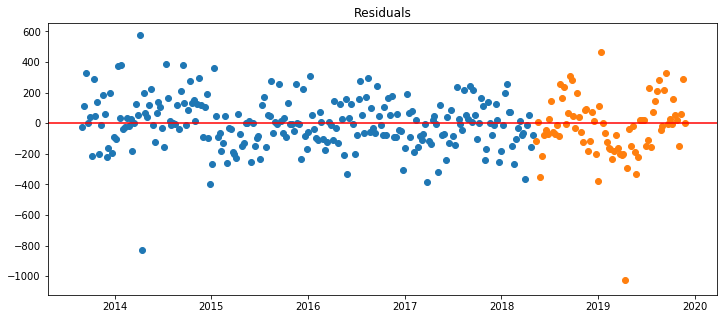

In [57]:
plt.figure(figsize = (12,5))
plt.scatter(train.index[1:], resids_train)
plt.scatter(test.index[1:], resids_test)
plt.title('Residuals')
plt.axhline(0, color='red')

{"mean square error": sum(np.square(resids_test)) / len(resids_test)}

{'mean square error': 41136.83086191557}

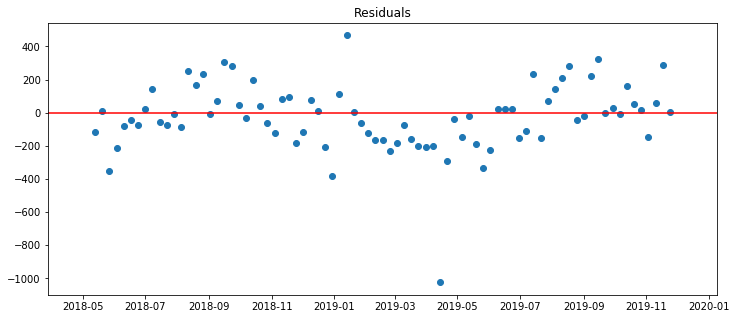

In [58]:
evaluate(test[1:], resids_test)

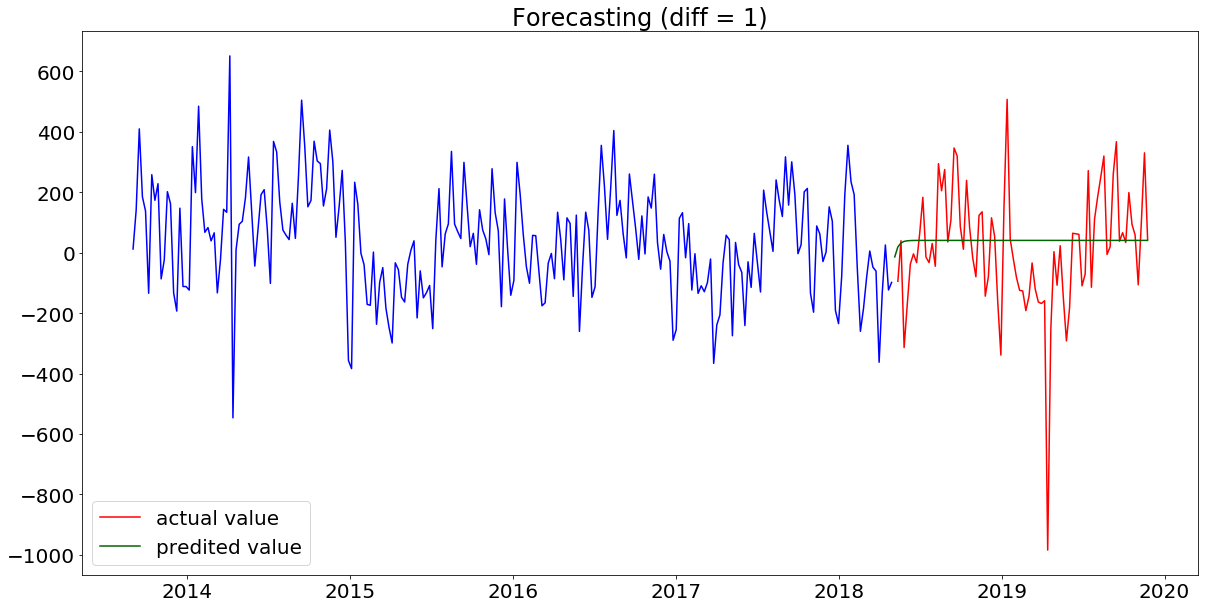

In [59]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index[1:], train.diff(1).dropna().values, color = 'blue')

# Plot testing data.
plt.plot(test.index[1:], test.diff(1).dropna().values, color = 'red', label = 'actual value')

# Plot predicted test values.
plt.plot(test.index, preds_test, color = 'darkgreen', label = 'predited value')

# Set label.
plt.title(label = 'Forecasting (diff = 1)', fontsize=24)
plt.legend(fontsize = 20)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

#### 2. Predicted Total Individuals in Shelter

In [60]:
preds_test_index = [train.index[-1]] + list(test.index[1:])
preds_test_original_index = [train.index[-1]] + list(test.index)
preds_test_original = np.cumsum([train[-1]] + list(preds_test))
resids_test_original = list([train[-1]] + list(test) - preds_test_original)

{'mean square error': 41136.83086191557}

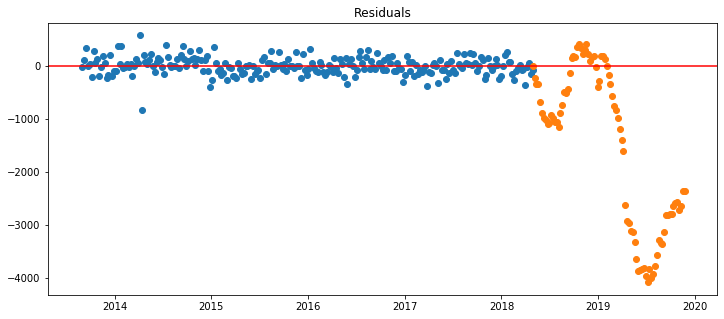

In [61]:
plt.figure(figsize = (12,5))
plt.scatter(train.index[1:], resids_train)
plt.scatter(preds_test_original_index, resids_test_original)
plt.title('Residuals')
plt.axhline(0, color='red')
{"mean square error": sum(np.square(resids_test)) / len(resids_test)}

{'mean square error': 4508666.790972115}

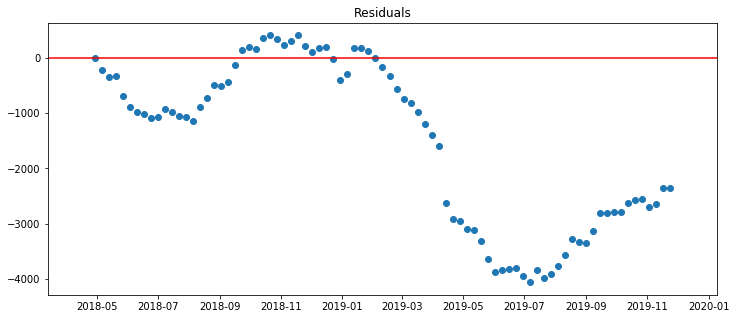

In [62]:
evaluate(weekly_df.iloc[len(train.index)-1:,:], resids_test_original)

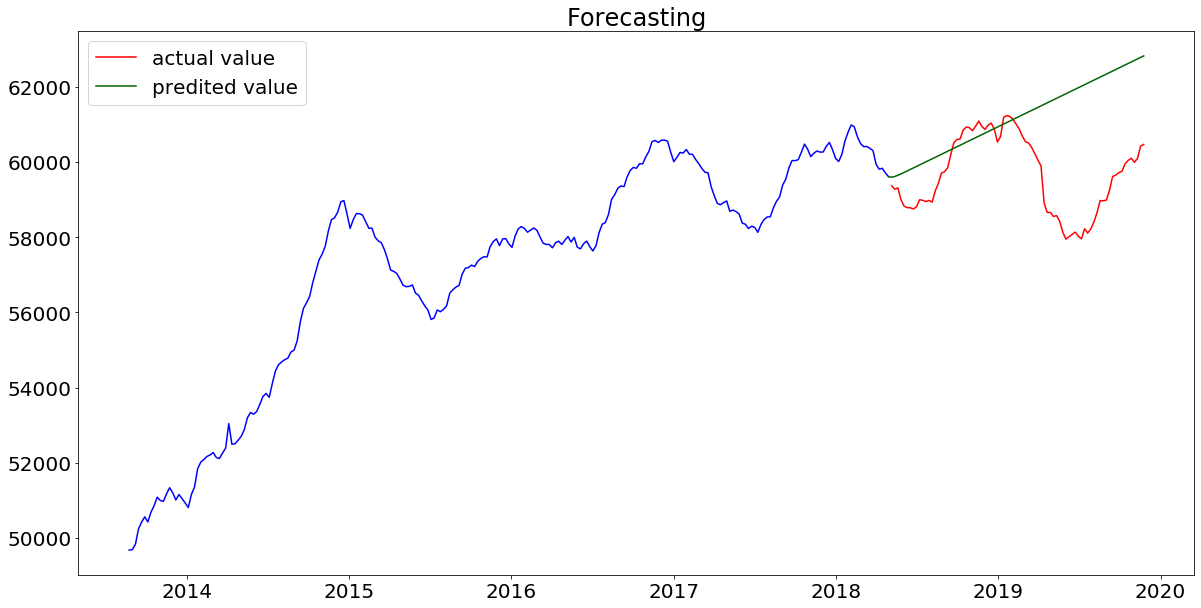

In [63]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index, train.values, color = 'blue')

# Plot testing data.
plt.plot(test.index, test.values, color = 'red', label = 'actual value')

# Plot predicted test values.
plt.plot(weekly_df.index[len(train.index)-1:], np.cumsum([train[-1]] + list(preds_test)), color = 'darkgreen', label = 'predited value')

# Set label.
plt.title(label = 'Forecasting', fontsize=24)
plt.legend(fontsize = 20)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

# SARIMA Model

- In seasonal_decompose plot, there seems to be seasonality. This was now indicated in PACF plot.
- However, when stationarity was achieved by differencing the data once, ACF and PACF curve indicate a sign of seasonality.
- Therefore, **Try SARIMA model**

### ACF, PACF plot (diff = 1)
- Shows a sign of seasonality

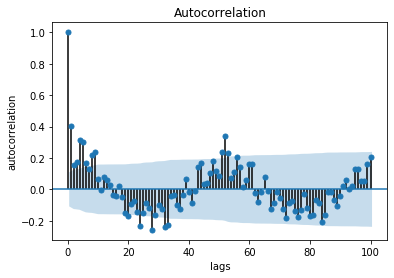

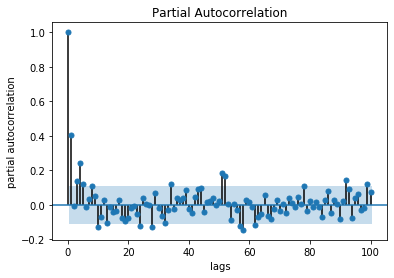

In [64]:
acf_pacf(weekly_df['total_individuals_in_shelter'].diff(1).dropna(), 100)

### Seasonal Decompose plot (diff = 0)
- Shows a sign of seasonality

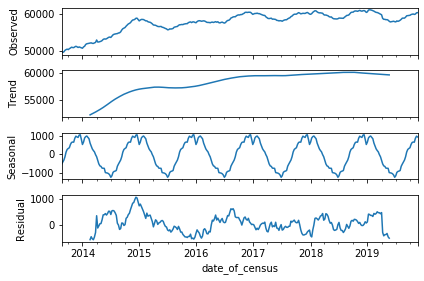

In [65]:
decomp = seasonal_decompose(weekly_df['total_individuals_in_shelter'].dropna())
decomp.plot();

### Seasonal Decompose plot (diff = 1)
- Shows a sign of seasonality

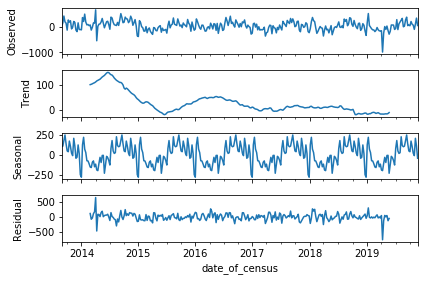

In [66]:
decomp = seasonal_decompose(weekly_df['total_individuals_in_shelter'].diff(1).dropna())
decomp.plot();

### Preliminary SARIMA
- There seems to be a seasonality every 52 weeks (1 year).
- Try `(P,D,Q,S)` = (0, 1, 0, 52)

991310.4527389193


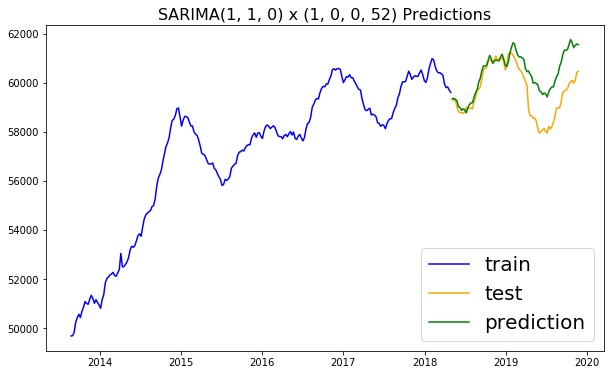

In [67]:
# Fit a SARIMA(0, 1, 0) x (0, 1, 0, 52) model.

sarima = SARIMAX(endog = train,
                 order = (0, 1, 0),              # (p, d, q)
                 seasonal_order = (0, 1, 0, 52) ) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start=test.index[0], # X_test data range
                      end=test.index[-1])
# Evaluate predictions.
print(mean_squared_error(test, preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train, color = 'blue', label = 'train')
plt.plot(test, color = 'orange', label = 'test')
plt.plot(preds, color = 'green', label = 'prediction')
plt.title(label = 'SARIMA(1, 1, 0) x (1, 0, 0, 52) Predictions', fontsize=16)
plt.legend(fontsize = 20)
plt.show();

In [68]:
preds_train = model.predict(start=train.index[0], # X_test data range
                            end=train.index[-1])

In [69]:
resids_train = list(train - preds_train)

resids_test = list(test - preds)

{'mean square error': 991310.4527389194}

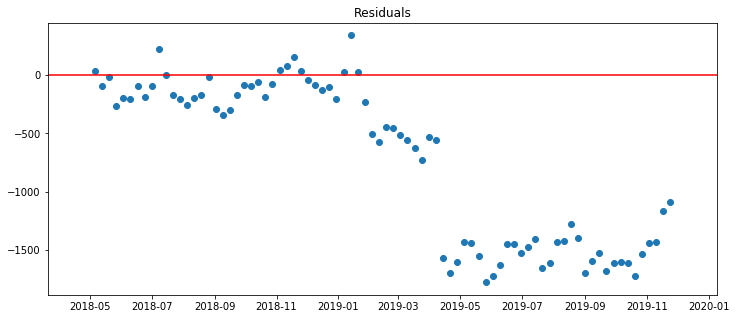

In [70]:
plt.figure(figsize = (12,5))
# plt.scatter(train.index[1:], resids_train[1:])
plt.scatter(test.index, resids_test)
plt.title('Residuals')
plt.axhline(0, color='red')

{"mean square error": sum(np.square(resids_test)) / len(resids_test)}

### Manual GridSearch
- Use grid search to find `seaonal_order`

In [71]:
# Starting MSE and (P, D, Q, S).
best_mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            for S in range(0,52,int(52/3)):
                try:
                    print(f'Attempting to fit SARIMAX(0,1,0)x({P},{D},{Q},{S})')
                    # Instantiate SARIMAX model.
                    sarimax = SARIMAX(endog = train,
                                      order = (0, 1, 0),              # (p, d, q)
                                      seasonal_order = (P, D, Q, S))  # (P, D, Q, S) 
                    # Fit SARIMAX model.
                    model = sarimax.fit()

                    # Generate predictions based on test set.
                    preds = model.predict(start=test.index[0], # X_test data range
                                          end=test.index[-1])

                    # Evaluate predictions.
                    print(f'The MSE for (0, 2, 1)x({P},{D},{Q},{S}) is: {mean_squared_error(test, preds)}')

                    # Save for final report.
                    if best_mse > mean_squared_error(test, preds):
                        best_mse = mean_squared_error(test, preds)
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S

                except:
                    pass

print(f'Our model that minimizes MSE on the testing data is the SARIMAX(0, 1, 0)x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an MSE of {best_mse}.')

Attempting to fit SARIMAX(0,1,0)x(0,0,0,0)
The MSE for (0, 2, 1)x(0,0,0,0) is: 1020947.7733325039
Attempting to fit SARIMAX(0,1,0)x(0,0,0,17)
The MSE for (0, 2, 1)x(0,0,0,17) is: 1020947.7733325039
Attempting to fit SARIMAX(0,1,0)x(0,0,0,34)
The MSE for (0, 2, 1)x(0,0,0,34) is: 1020947.7733325039
Attempting to fit SARIMAX(0,1,0)x(0,0,0,51)
The MSE for (0, 2, 1)x(0,0,0,51) is: 1020947.7733325039
Attempting to fit SARIMAX(0,1,0)x(0,1,0,0)
Attempting to fit SARIMAX(0,1,0)x(0,1,0,17)
The MSE for (0, 2, 1)x(0,1,0,17) is: 1920152.9950569533
Attempting to fit SARIMAX(0,1,0)x(0,1,0,34)
The MSE for (0, 2, 1)x(0,1,0,34) is: 2144763.4614520934
Attempting to fit SARIMAX(0,1,0)x(0,1,0,51)
The MSE for (0, 2, 1)x(0,1,0,51) is: 2034330.5033528344
Attempting to fit SARIMAX(0,1,0)x(0,2,0,0)
Attempting to fit SARIMAX(0,1,0)x(0,2,0,17)
The MSE for (0, 2, 1)x(0,2,0,17) is: 77703824.29734778
Attempting to fit SARIMAX(0,1,0)x(0,2,0,34)
The MSE for (0, 2, 1)x(0,2,0,34) is: 31616178.0594575
Attempting to fit S

/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 2, 1)x(0,1,1,51) is: 2786391.266139923
Attempting to fit SARIMAX(0,1,0)x(0,2,1,0)
Attempting to fit SARIMAX(0,1,0)x(0,2,1,17)
The MSE for (0, 2, 1)x(0,2,1,17) is: 7971825.711041945
Attempting to fit SARIMAX(0,1,0)x(0,2,1,34)
The MSE for (0, 2, 1)x(0,2,1,34) is: 2354868.23249843
Attempting to fit SARIMAX(0,1,0)x(0,2,1,51)
Attempting to fit SARIMAX(0,1,0)x(0,0,2,0)
The MSE for (0, 2, 1)x(0,0,2,0) is: 1025777.7998492131
Attempting to fit SARIMAX(0,1,0)x(0,0,2,17)
The MSE for (0, 2, 1)x(0,0,2,17) is: 1051849.4966794013
Attempting to fit SARIMAX(0,1,0)x(0,0,2,34)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 2, 1)x(0,0,2,34) is: 969210.7546801805
Attempting to fit SARIMAX(0,1,0)x(0,0,2,51)
Attempting to fit SARIMAX(0,1,0)x(0,1,2,0)
Attempting to fit SARIMAX(0,1,0)x(0,1,2,17)
The MSE for (0, 2, 1)x(0,1,2,17) is: 1311278.7515942014
Attempting to fit SARIMAX(0,1,0)x(0,1,2,34)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 2, 1)x(0,1,2,34) is: 1547618.574384665
Attempting to fit SARIMAX(0,1,0)x(0,1,2,51)
Attempting to fit SARIMAX(0,1,0)x(0,2,2,0)
Attempting to fit SARIMAX(0,1,0)x(0,2,2,17)
The MSE for (0, 2, 1)x(0,2,2,17) is: 4763486.343631804
Attempting to fit SARIMAX(0,1,0)x(0,2,2,34)
Attempting to fit SARIMAX(0,1,0)x(0,2,2,51)
Attempting to fit SARIMAX(0,1,0)x(1,0,0,0)
The MSE for (0, 2, 1)x(1,0,0,0) is: 1028070.8907725526
Attempting to fit SARIMAX(0,1,0)x(1,0,0,17)
The MSE for (0, 2, 1)x(1,0,0,17) is: 1042591.2135971283
Attempting to fit SARIMAX(0,1,0)x(1,0,0,34)
The MSE for (0, 2, 1)x(1,0,0,34) is: 1019693.1401362966
Attempting to fit SARIMAX(0,1,0)x(1,0,0,51)
The MSE for (0, 2, 1)x(1,0,0,51) is: 884398.0048150518
Attempting to fit SARIMAX(0,1,0)x(1,1,0,0)
Attempting to fit SARIMAX(0,1,0)x(1,1,0,17)
The MSE for (0, 2, 1)x(1,1,0,17) is: 1054268.97515247
Attempting to fit SARIMAX(0,1,0)x(1,1,0,34)
The MSE for (0, 2, 1)x(1,1,0,34) is: 1195307.4392547777
Attempting to fit SARIMAX(0,1,0)x

/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 2, 1)x(1,1,1,51) is: 3309644.582039435
Attempting to fit SARIMAX(0,1,0)x(1,2,1,0)
Attempting to fit SARIMAX(0,1,0)x(1,2,1,17)
The MSE for (0, 2, 1)x(1,2,1,17) is: 6572654.029526924
Attempting to fit SARIMAX(0,1,0)x(1,2,1,34)
The MSE for (0, 2, 1)x(1,2,1,34) is: 2076866.9988108582
Attempting to fit SARIMAX(0,1,0)x(1,2,1,51)
Attempting to fit SARIMAX(0,1,0)x(1,0,2,0)
The MSE for (0, 2, 1)x(1,0,2,0) is: 1380053.4585209824
Attempting to fit SARIMAX(0,1,0)x(1,0,2,17)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 2, 1)x(1,0,2,17) is: 1028548.8980709901
Attempting to fit SARIMAX(0,1,0)x(1,0,2,34)
The MSE for (0, 2, 1)x(1,0,2,34) is: 1010223.3562454546
Attempting to fit SARIMAX(0,1,0)x(1,0,2,51)
Attempting to fit SARIMAX(0,1,0)x(1,1,2,0)
Attempting to fit SARIMAX(0,1,0)x(1,1,2,17)
The MSE for (0, 2, 1)x(1,1,2,17) is: 1283893.999303597
Attempting to fit SARIMAX(0,1,0)x(1,1,2,34)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 2, 1)x(1,1,2,34) is: 1461607.056550824
Attempting to fit SARIMAX(0,1,0)x(1,1,2,51)
Attempting to fit SARIMAX(0,1,0)x(1,2,2,0)
Attempting to fit SARIMAX(0,1,0)x(1,2,2,17)
The MSE for (0, 2, 1)x(1,2,2,17) is: 1383134.3215208075
Attempting to fit SARIMAX(0,1,0)x(1,2,2,34)
Attempting to fit SARIMAX(0,1,0)x(1,2,2,51)
Attempting to fit SARIMAX(0,1,0)x(2,0,0,0)
The MSE for (0, 2, 1)x(2,0,0,0) is: 1031715.8189067675
Attempting to fit SARIMAX(0,1,0)x(2,0,0,17)
The MSE for (0, 2, 1)x(2,0,0,17) is: 1044397.602886625
Attempting to fit SARIMAX(0,1,0)x(2,0,0,34)
The MSE for (0, 2, 1)x(2,0,0,34) is: 986936.1880875194
Attempting to fit SARIMAX(0,1,0)x(2,0,0,51)
The MSE for (0, 2, 1)x(2,0,0,51) is: 845446.4841995126
Attempting to fit SARIMAX(0,1,0)x(2,1,0,0)
Attempting to fit SARIMAX(0,1,0)x(2,1,0,17)
The MSE for (0, 2, 1)x(2,1,0,17) is: 1155304.4078237968
Attempting to fit SARIMAX(0,1,0)x(2,1,0,34)
The MSE for (0, 2, 1)x(2,1,0,34) is: 1440087.9997751443
Attempting to fit SARIMAX(0,1,0)

/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 2, 1)x(2,0,1,0) is: 1382326.4909825458
Attempting to fit SARIMAX(0,1,0)x(2,0,1,17)
The MSE for (0, 2, 1)x(2,0,1,17) is: 1019431.9490025189
Attempting to fit SARIMAX(0,1,0)x(2,0,1,34)
The MSE for (0, 2, 1)x(2,0,1,34) is: 1011813.6914699489
Attempting to fit SARIMAX(0,1,0)x(2,0,1,51)
The MSE for (0, 2, 1)x(2,0,1,51) is: 1382461.016889832
Attempting to fit SARIMAX(0,1,0)x(2,1,1,0)
Attempting to fit SARIMAX(0,1,0)x(2,1,1,17)
The MSE for (0, 2, 1)x(2,1,1,17) is: 1092656.6778637161
Attempting to fit SARIMAX(0,1,0)x(2,1,1,34)
The MSE for (0, 2, 1)x(2,1,1,34) is: 992388.0240765096
Attempting to fit SARIMAX(0,1,0)x(2,1,1,51)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 2, 1)x(2,1,1,51) is: 4787515.933400795
Attempting to fit SARIMAX(0,1,0)x(2,2,1,0)
Attempting to fit SARIMAX(0,1,0)x(2,2,1,17)
The MSE for (0, 2, 1)x(2,2,1,17) is: 1553013.2616228343
Attempting to fit SARIMAX(0,1,0)x(2,2,1,34)
The MSE for (0, 2, 1)x(2,2,1,34) is: 1711610.4686332052
Attempting to fit SARIMAX(0,1,0)x(2,2,1,51)
Attempting to fit SARIMAX(0,1,0)x(2,0,2,0)
The MSE for (0, 2, 1)x(2,0,2,0) is: 1389337.6651709531
Attempting to fit SARIMAX(0,1,0)x(2,0,2,17)
The MSE for (0, 2, 1)x(2,0,2,17) is: 1024584.6387659325
Attempting to fit SARIMAX(0,1,0)x(2,0,2,34)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 2, 1)x(2,0,2,34) is: 611764.0229182794
Attempting to fit SARIMAX(0,1,0)x(2,0,2,51)
Attempting to fit SARIMAX(0,1,0)x(2,1,2,0)
Attempting to fit SARIMAX(0,1,0)x(2,1,2,17)
The MSE for (0, 2, 1)x(2,1,2,17) is: 1140624.2457179634
Attempting to fit SARIMAX(0,1,0)x(2,1,2,34)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (0, 2, 1)x(2,1,2,34) is: 1113765.3420362056
Attempting to fit SARIMAX(0,1,0)x(2,1,2,51)
Attempting to fit SARIMAX(0,1,0)x(2,2,2,0)
Attempting to fit SARIMAX(0,1,0)x(2,2,2,17)
The MSE for (0, 2, 1)x(2,2,2,17) is: 1544384.5983278786
Attempting to fit SARIMAX(0,1,0)x(2,2,2,34)
Attempting to fit SARIMAX(0,1,0)x(2,2,2,51)
Our model that minimizes MSE on the testing data is the SARIMAX(0, 1, 0)x(2,0,2,34).
This model has an MSE of 611764.0229182794.


In [72]:
# Starting MSE and (P, D, Q, S).
best_mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            for S in [3, 4, 51, 52]: 
                # testing monthly seasonality with 3,4
                # testing yearly seaonailty with 51, 52
                try:
                    print(f'Attempting to fit SARIMAX(0,1,0)x({P},{D},{Q},{S})')
                    # Instantiate SARIMAX model.
                    sarimax = SARIMAX(endog = train,
                                      order = (0, 1, 0),              # (p, d, q)
                                      seasonal_order = (P, D, Q, S))  # (P, D, Q, S) 
                    # Fit SARIMAX model.
                    model = sarimax.fit()

                    # Generate predictions based on test set.
                    preds = model.predict(start=test.index[0], # X_test data range
                                          end=test.index[-1])

                    # Evaluate predictions.
                    print(f'The MSE for (0, 1, 0)x({P},{D},{Q},{S}) is: {mean_squared_error(test, preds)}')

                    # Save for final report.
                    if best_mse > mean_squared_error(test, preds):
                        best_mse = mean_squared_error(test, preds)
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S

                except:
                    pass

print(f'Our model that minimizes MSE on the testing data is the SARIMAX(0, 1, 0)x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an MSE of {best_mse}.')

Attempting to fit SARIMAX(0,1,0)x(0,0,0,3)
The MSE for (0, 1, 0)x(0,0,0,3) is: 1020947.7733325039
Attempting to fit SARIMAX(0,1,0)x(0,0,0,4)
The MSE for (0, 1, 0)x(0,0,0,4) is: 1020947.7733325039
Attempting to fit SARIMAX(0,1,0)x(0,0,0,51)
The MSE for (0, 1, 0)x(0,0,0,51) is: 1020947.7733325039
Attempting to fit SARIMAX(0,1,0)x(0,0,0,52)
The MSE for (0, 1, 0)x(0,0,0,52) is: 1020947.7733325039
Attempting to fit SARIMAX(0,1,0)x(0,1,0,3)
The MSE for (0, 1, 0)x(0,1,0,3) is: 10461508.332841933
Attempting to fit SARIMAX(0,1,0)x(0,1,0,4)
The MSE for (0, 1, 0)x(0,1,0,4) is: 16265924.562282033
Attempting to fit SARIMAX(0,1,0)x(0,1,0,51)
The MSE for (0, 1, 0)x(0,1,0,51) is: 2034330.5033528344
Attempting to fit SARIMAX(0,1,0)x(0,1,0,52)
The MSE for (0, 1, 0)x(0,1,0,52) is: 991310.4527389193
Attempting to fit SARIMAX(0,1,0)x(0,2,0,3)
The MSE for (0, 1, 0)x(0,2,0,3) is: 3732390278.948957
Attempting to fit SARIMAX(0,1,0)x(0,2,0,4)
The MSE for (0, 1, 0)x(0,2,0,4) is: 77500218.85893044
Attempting to f

/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(0,1,1,51) is: 2786391.266139923
Attempting to fit SARIMAX(0,1,0)x(0,1,1,52)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(0,1,1,52) is: 2137124.3077582065
Attempting to fit SARIMAX(0,1,0)x(0,2,1,3)
The MSE for (0, 1, 0)x(0,2,1,3) is: 84570304.72183983
Attempting to fit SARIMAX(0,1,0)x(0,2,1,4)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(0,2,1,4) is: 69837348.20462663
Attempting to fit SARIMAX(0,1,0)x(0,2,1,51)
Attempting to fit SARIMAX(0,1,0)x(0,2,1,52)
Attempting to fit SARIMAX(0,1,0)x(0,0,2,3)
The MSE for (0, 1, 0)x(0,0,2,3) is: 1027458.3306513461
Attempting to fit SARIMAX(0,1,0)x(0,0,2,4)
The MSE for (0, 1, 0)x(0,0,2,4) is: 1045840.6871031177
Attempting to fit SARIMAX(0,1,0)x(0,0,2,51)
Attempting to fit SARIMAX(0,1,0)x(0,0,2,52)
Attempting to fit SARIMAX(0,1,0)x(0,1,2,3)
The MSE for (0, 1, 0)x(0,1,2,3) is: 8969365.146002116
Attempting to fit SARIMAX(0,1,0)x(0,1,2,4)
The MSE for (0, 1, 0)x(0,1,2,4) is: 8059583.668701452
Attempting to fit SARIMAX(0,1,0)x(0,1,2,51)
Attempting to fit SARIMAX(0,1,0)x(0,1,2,52)
Attempting to fit SARIMAX(0,1,0)x(0,2,2,3)
The MSE for (0, 1, 0)x(0,2,2,3) is: 62260990.39974739
Attempting to fit SARIMAX(0,1,0)x(0,2,2,4)
The MSE for (0, 1, 0)x(0,2,2,4) is: 57887919.40943111
Attempting to fit SARIMAX(0,1,0)x(0,2,2,51)
Attempting to fit SARIMAX(0,1,0)x(0,2,2,52)
Attempting

/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(1,1,1,51) is: 3309644.582039435
Attempting to fit SARIMAX(0,1,0)x(1,1,1,52)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(1,1,1,52) is: 1720877.5622153406
Attempting to fit SARIMAX(0,1,0)x(1,2,1,3)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(1,2,1,3) is: 80452002.62039088
Attempting to fit SARIMAX(0,1,0)x(1,2,1,4)
The MSE for (0, 1, 0)x(1,2,1,4) is: 62790597.94453078
Attempting to fit SARIMAX(0,1,0)x(1,2,1,51)
Attempting to fit SARIMAX(0,1,0)x(1,2,1,52)
Attempting to fit SARIMAX(0,1,0)x(1,0,2,3)
The MSE for (0, 1, 0)x(1,0,2,3) is: 1244948.1588736728
Attempting to fit SARIMAX(0,1,0)x(1,0,2,4)
The MSE for (0, 1, 0)x(1,0,2,4) is: 1187866.7937087237
Attempting to fit SARIMAX(0,1,0)x(1,0,2,51)
Attempting to fit SARIMAX(0,1,0)x(1,0,2,52)
Attempting to fit SARIMAX(0,1,0)x(1,1,2,3)
The MSE for (0, 1, 0)x(1,1,2,3) is: 10845699.896015484
Attempting to fit SARIMAX(0,1,0)x(1,1,2,4)
The MSE for (0, 1, 0)x(1,1,2,4) is: 1175629.8935503867
Attempting to fit SARIMAX(0,1,0)x(1,1,2,51)
Attempting to fit SARIMAX(0,1,0)x(1,1,2,52)
Attempting to fit SARIMAX(0,1,0)x(1,2,2,3)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(1,2,2,3) is: 86952903.30332448
Attempting to fit SARIMAX(0,1,0)x(1,2,2,4)
The MSE for (0, 1, 0)x(1,2,2,4) is: 2367028.577012731
Attempting to fit SARIMAX(0,1,0)x(1,2,2,51)
Attempting to fit SARIMAX(0,1,0)x(1,2,2,52)
Attempting to fit SARIMAX(0,1,0)x(2,0,0,3)
The MSE for (0, 1, 0)x(2,0,0,3) is: 1057669.700085516
Attempting to fit SARIMAX(0,1,0)x(2,0,0,4)
The MSE for (0, 1, 0)x(2,0,0,4) is: 1141650.6857155734
Attempting to fit SARIMAX(0,1,0)x(2,0,0,51)
The MSE for (0, 1, 0)x(2,0,0,51) is: 845446.4841995126
Attempting to fit SARIMAX(0,1,0)x(2,0,0,52)
The MSE for (0, 1, 0)x(2,0,0,52) is: 787112.1450267485
Attempting to fit SARIMAX(0,1,0)x(2,1,0,3)
The MSE for (0, 1, 0)x(2,1,0,3) is: 20970229.446461763
Attempting to fit SARIMAX(0,1,0)x(2,1,0,4)
The MSE for (0, 1, 0)x(2,1,0,4) is: 22298843.08412163
Attempting to fit SARIMAX(0,1,0)x(2,1,0,51)
The MSE for (0, 1, 0)x(2,1,0,51) is: 2341010.7975350684
Attempting to fit SARIMAX(0,1,0)x(2,1,0,52)
The MSE for (0, 1, 0)x(2,1,0,

/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(2,1,1,51) is: 4787515.933400795
Attempting to fit SARIMAX(0,1,0)x(2,1,1,52)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(2,1,1,52) is: 2833091.9374599895
Attempting to fit SARIMAX(0,1,0)x(2,2,1,3)
The MSE for (0, 1, 0)x(2,2,1,3) is: 63993970.097890876
Attempting to fit SARIMAX(0,1,0)x(2,2,1,4)
The MSE for (0, 1, 0)x(2,2,1,4) is: 62926741.869155094
Attempting to fit SARIMAX(0,1,0)x(2,2,1,51)
Attempting to fit SARIMAX(0,1,0)x(2,2,1,52)
Attempting to fit SARIMAX(0,1,0)x(2,0,2,3)
The MSE for (0, 1, 0)x(2,0,2,3) is: 449761.1901315042
Attempting to fit SARIMAX(0,1,0)x(2,0,2,4)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (0, 1, 0)x(2,0,2,4) is: 447982.6202097937
Attempting to fit SARIMAX(0,1,0)x(2,0,2,51)
Attempting to fit SARIMAX(0,1,0)x(2,0,2,52)
Attempting to fit SARIMAX(0,1,0)x(2,1,2,3)
The MSE for (0, 1, 0)x(2,1,2,3) is: 26049512.93644529
Attempting to fit SARIMAX(0,1,0)x(2,1,2,4)
The MSE for (0, 1, 0)x(2,1,2,4) is: 1170180.3879545718
Attempting to fit SARIMAX(0,1,0)x(2,1,2,51)
Attempting to fit SARIMAX(0,1,0)x(2,1,2,52)
Attempting to fit SARIMAX(0,1,0)x(2,2,2,3)
The MSE for (0, 1, 0)x(2,2,2,3) is: 61038335.23970449
Attempting to fit SARIMAX(0,1,0)x(2,2,2,4)
The MSE for (0, 1, 0)x(2,2,2,4) is: 13966015.386516266
Attempting to fit SARIMAX(0,1,0)x(2,2,2,51)
Attempting to fit SARIMAX(0,1,0)x(2,2,2,52)
Our model that minimizes MSE on the testing data is the SARIMAX(0, 1, 0)x(2,2,0,52).
This model has an MSE of 245042.42024590212.


Both gridsearch indicates that **SARIMAX(0, 2, 1)x(2,2,0,51)** minimizes MSE.

245042.42024590212


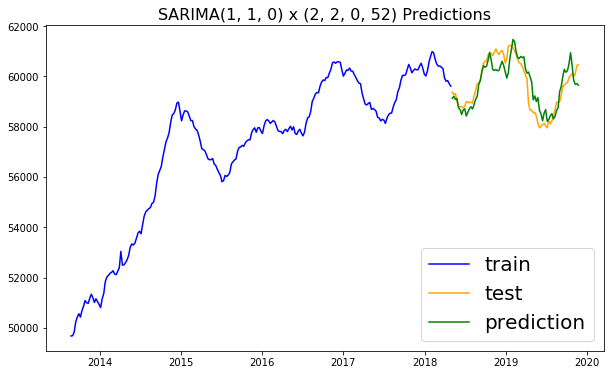

In [76]:
# Fit a SARIMA(0, 1, 0) x (2, 2, 0, 51) model.

sarima = SARIMAX(endog = train,
                 order = (0, 1, 0),              # (p, d, q)
                 seasonal_order = (2, 2, 0, 52) ) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start=test.index[0], # X_test data range
                      end=test.index[-1])
# Evaluate predictions.
print(mean_squared_error(test, preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train, color = 'blue', label = 'train')
plt.plot(test, color = 'orange', label = 'test')
plt.plot(preds, color = 'green', label = 'prediction')
plt.title(label = 'SARIMA(1, 1, 0) x (2, 2, 0, 52) Predictions', fontsize=16)
plt.legend(fontsize = 20)
plt.show();

In [77]:
resids = list(test - preds)

{'mean square error': 245042.42024590206}

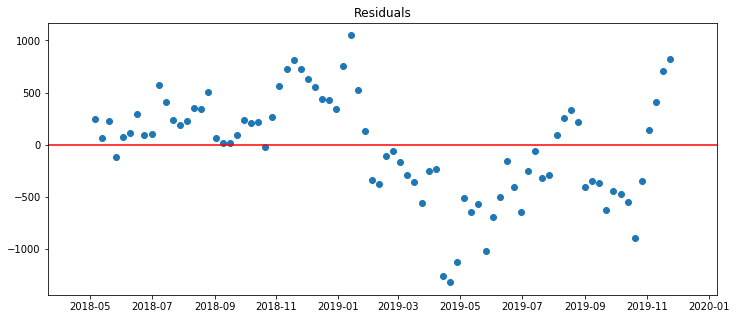

In [78]:
evaluate(test, resids)